# Fold Cross-Validation to Determine Best Set of Coefficients

In [1]:
import numpy as np
from sklearn import datasets, linear_model
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
x_list = []
labels = []
names = []
first_line = True
data_path = './data/winequality-red.csv'

with open(data_path) as data:
        
    for line in data:
        
        if first_line:
            names = line.strip().split(';')
            first_line = False
            
        else:
            # split on semicolon
            row = line.strip().split(';')
            
            # put labels in separate array
            labels.append(float(row[-1]))
            
            # remove label from row
            row.pop()
            
            # convert row to floats
            float_row = [float(num) for num in row]
            x_list.append(float_row)
            

In [3]:
# Normalize columns in x and labels

n_rows = len(x_list)
n_cols = len(x_list[0])

# calculate means and variances
x_means = []
x_sd = []

for i in range(n_cols):
    col = [x_list[j][i] for j in range(n_rows)]
    mean = sum(col)/n_rows
    x_means.append(mean)
    
    col_diff = [(x_list[j][i] - mean) for j in range(n_rows)]
    sum_sq = sum([col_diff[i] ** 2 for i in range(n_rows)])
    std_dev = sqrt(sum_sq/n_rows)
    x_sd.append(std_dev)

# Use calculated mean and standard deviation to normalize x_list

x_normalized = []

for i in range(n_rows):
    row_normalized = [(x_list[i][j] - x_means[j])/x_sd[j] for j in range(n_cols)]
    x_normalized.append(row_normalized)
    
# normalize labels

mean_label = sum(labels)/n_rows
sd_label = sqrt(sum([(labels[i] - mean_label) * (labels[i] - mean_label) for i in range(n_rows)])/n_rows)

label_normalized = [(labels[i] - mean_label)/sd_label for i in range(n_rows)]

In [4]:
# Build cross-validation loop to determine best coefficient values

# number of cross-validation folds
n_x_val = 10

# number of steps and step size
n_steps = 350
step_size = 0.004

# initialize list for storing errors
errors = []

for i in range(n_steps):
    b = []
    errors.append(b)
    
for i_x_val in range(n_x_val):
    
    # Define test and training index sets
    idx_test = [a for a in range(n_rows) if a % n_x_val == i_x_val * n_x_val]
    idx_train = [a for a in range(n_rows) if a % n_x_val != i_x_val * n_x_val]

    # Define test and training attributes and label sets
    x_train = [x_normalized[r] for r in idx_train]
    x_test = [x_normalized[r] for r in idx_test]
    label_train = [label_normalized[r] for r in idx_train]
    label_test = [label_normalized[r] for r in idx_test]
    
    # Train LARS regression on training data
    n_rows_train = len(idx_train)
    n_rows_test = len(idx_test)
    
    # initialize a vector of coefficients beta
    beta  = [0.0] * n_cols
    
    # initialize a matrix of betas at each step
    beta_mat = []
    beta_mat.append(list(beta))
    
    for i_step in range(n_steps):
        
        # calculate residuals
        residuals = [0.0] * n_rows
        
        for j in range(n_rows_train):
            labels_hat = sum([x_train[j][k] * beta[k] for k in range(n_cols)])
            residuals[j] = label_train[j] - labels_hat
            
        # calculate correlation between attribute columns from normalized wine and rseidual
        corr = [0.0] * n_cols
        
        for j in range(n_cols):
            corr[j] = sum([x_train[k][j] * residuals[k] for k in range(n_rows_train)])/n_rows_train
            
        i_star = 0
        corr_star = corr[0]
        
        for j in range(1, n_cols):
            
            if abs(corr_star) < abs(corr[j]):
                i_star = j
                corr_star = corr[j]
                
        beta[i_star] += step_size * corr_star / abs(corr_star)
        beta_mat.append(list(beta))
        
        # Use beta just calculated to predict and accumulate out of sample error - not being used in the calc of beta
        for j in range(n_rows_test):
            labels_hat = sum([x_test[j][k] * beta[k] for k in range(n_cols)])
            err = label_test[j] - labels_hat
            errors[i_step].append(err)


In [5]:
cv_curve = []

for err_vect in errors:
    mse = sum([x * x for x in err_vect])/len(err_vect)
    cv_curve.append(mse)
    
min_mse = min(cv_curve)
min_pt = [i for i in range(len(cv_curve)) if cv_curve[i] == min_mse][0]

print(f'Minimum Mean Square Error: {min_mse}')
print(f'Index of Minimum Mean Square Error: {min_pt}')

Minimum Mean Square Error: 0.5873018933136459
Index of Minimum Mean Square Error: 311


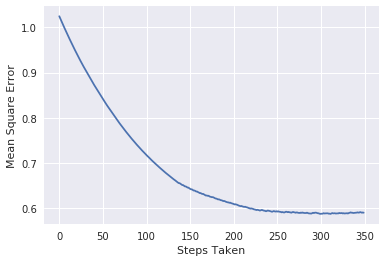

In [6]:
x_axis = range(len(cv_curve))
plt.plot(x_axis, cv_curve)
plt.xlabel('Steps Taken')
plt.ylabel('Mean Square Error')
plt.show()